# <font color=green> **AULA PRÁTICA 8**
-----



#**Retail Demand Forecasting**


A referência do tema foi adquirida na página:

https://towardsdatascience.com/machine-learning-for-store-demand-forecasting-and-inventory-optimization-part-1-xgboost-vs-9952d8303b48

<br>

O artigo do site propõe a resolução do problema de **"Otimização de Planejamento de Demanda"** com a previsão da demanda de cada produto de cada uma das lojas.

Nesta aula, iremos reduzir e utilizar os dados fornecidos para mostrar como podemos avaliar séries temporais e propor modelos de previsão de demanda.

**OBS:** O objetivo não é resolver o problema do desafio, mas fornecer uma introdução em como podemos lidar com séries temporais e previsões.

## 1 - Descrição dos Dados

**Onde acessar?**

* https://www.kaggle.com/c/demand-forecasting-kernels-only/data

<br> 

**Qual o objetivo da competição?**

* Prever 3 meses da venda de um determinado item em diferentes localizações da loja

<br>

**Quais dados são disponibilizados?**

* Training data test.csv
* Test data (Note: the Public/Private split is time based) 
* Sample_submission.csv - a sample submission file in the correct format

<br>

**Quais são as variáveis?**

* **date** - Date of the sale data. There are no holiday effects or store closures. 
* **store** - Store ID item 
* **Item ID** 
* **sales** - Number of items sold at a particular store on a particular date.



## 2 - Importando os dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt           
import seaborn as sns                    
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# lendo arquivos de treino  e teste
df_treino = pd.read_csv('/content/drive/Shareddrives/Disciplina Modelagem/Aulas/Aula 8/train.csv')
df_teste = pd.read_csv('/content/drive/Shareddrives/Disciplina Modelagem/Aulas/Aula 8/test.csv')

In [3]:
df_treino

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
df_teste

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


Notar que o conjunto de teste não tem "sales". Ou seja, esse dataframe é apenas uma amostras das datas do desafio que deverão ser previstas. Para o que queremos analisar, não será um conjunto útil.

## 3- Análise Exploratória dos dados

In [5]:
df_treino.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
# tamanho da série de treino
df_treino.shape

(913000, 4)

In [7]:
# elementos na coluna store? são então 10 lojas, com 91300 registros cada
df_treino['store'].value_counts()

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64

In [8]:
df_treino.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
## quantos itens diferentes?
print(f"Número de itens diferentes: {len(df_treino['item'].unique())}")
df_treino['item'].unique()

Número de itens diferentes: 50


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [10]:
pd.to_datetime(df_treino['date'])

0        2013-01-01
1        2013-01-02
2        2013-01-03
3        2013-01-04
4        2013-01-05
            ...    
912995   2017-12-27
912996   2017-12-28
912997   2017-12-29
912998   2017-12-30
912999   2017-12-31
Name: date, Length: 913000, dtype: datetime64[ns]

In [11]:
# transformando as datas para time
df_treino['date'] = pd.to_datetime(df_treino['date'])   # sempre precisa passar data para esse formato
df_treino.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [12]:
# RESUMO ESTATÍSTICO
df_treino.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [13]:
df_treino.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [14]:
# qual seria a venda por ano? e por mês? por dia?
df_treino['date'] = pd.to_datetime(df_treino['date'])
df_treino['year'] = df_treino.date.dt.year              # da variável date, pega o ano
df_treino['month'] = df_treino.date.dt.month            # da variável date, pega o mês
df_treino['day'] = df_treino.date.dt.day                # da variável date, pega o dia
df_treino['dayofyear'] = df_treino.date.dt.dayofyear      # da variável date, pega o dia do ano
df_treino['dayofweek'] = df_treino.date.dt.dayofweek    # da variável date, pega o dia da semana  - Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
df_treino['weekofyear'] = df_treino.date.dt.weekofyear   # da variável date, pega o dia da semana do ano

In [15]:
# o que significa primeira semana do ano?
df_treino.loc[df_treino['weekofyear'] == 1,:].loc[0:400,:]

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1
5,2013-01-06,1,1,12,2013,1,6,6,6,1
363,2013-12-30,1,1,5,2013,12,30,364,0,1
364,2013-12-31,1,1,15,2013,12,31,365,1,1
365,2014-01-01,1,1,9,2014,1,1,1,2,1
366,2014-01-02,1,1,14,2014,1,2,2,3,1


In [16]:
# o que a gente faz para treino, a gente tem que fazer para teste:
def time_operations(df):
    # qual seria a venda por ano? e por mês? por dia?
  df['date'] = pd.to_datetime(df['date'])
  df['year'] = df.date.dt.year              # da variável date, pega o ano
  df['month'] = df.date.dt.month            # da variável date, pega o mês
  df['day'] = df.date.dt.day                # da variável date, pega o dia
  df['dayofyear'] = df.date.dt.dayofyear      # da variável date, pega o dia do ano
  df['dayofweek'] = df.date.dt.dayofweek    # da variável date, pega o dia da semana  - Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
  df['weekofyear'] = df.date.dt.weekofyear   # da variável date, pega o dia da semana do ano
  return(df)

df_treino = time_operations(df_treino)

In [17]:
df_treino

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1
...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,27,361,2,52
912996,2017-12-28,10,50,59,2017,12,28,362,3,52
912997,2017-12-29,10,50,74,2017,12,29,363,4,52
912998,2017-12-30,10,50,62,2017,12,30,364,5,52


### Olhando apenas para o item 1

A fim de simplificar nosso problema, vamos verificar apenas o item 1.

In [18]:
df_item1 = df_treino.loc[df_treino['item']==1,:]  # filtrando pelo item 1
df_item1.head()

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1


In [19]:
df_item1.shape

(18260, 10)

Gráficos interativos

In [20]:
df_item1.head()

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1


In [21]:
# gráfico interativo
import plotly.graph_objects as go
import plotly.express as px

fig2 = px.line(df_item1, x='date', y='sales', color="store",color_discrete_sequence=px.colors.qualitative.G10)
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))


fig2.show(renderer="colab")

A partir do gráfico acima, o que podemos perceber?

Um outro ponto interessante é que muitas vezes precisamos mudar a frequência dos nossos dados. Mas o que significa mudar a frequência dos dados da série temporal? 

Ou seja, mudar de mês para ano, ou minuto para hora. Se faz sentido prever seus dados a cada mês, e eles estão com intervalo de dia, precisamos passar de dias para mês, escolhendo alguma medida apropriada.


Podemos usar a função **resample** do pandas, exclusiva para séries temporais.

In [22]:
# Para loja 1:
store1 = 1
df_item1.loc[df_item1['store'] == store1,:].head()

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1


In [23]:
# Exemplo de como podemos transformar para outra frequência com resample
df_item1.loc[df_item1['store'] == store1,:].resample('M', on= 'date',convention ='start')['sales'].sum()

date
2013-01-31    328
2013-02-28    322
2013-03-31    477
2013-04-30    522
2013-05-31    531
2013-06-30    627
2013-07-31    661
2013-08-31    594
2013-09-30    519
2013-10-31    484
2013-11-30    572
2013-12-31    388
2014-01-31    435
2014-02-28    405
2014-03-31    549
2014-04-30    573
2014-05-31    651
2014-06-30    710
2014-07-31    746
2014-08-31    671
2014-09-30    566
2014-10-31    555
2014-11-30    619
2014-12-31    409
2015-01-31    428
2015-02-28    399
2015-03-31    552
2015-04-30    652
2015-05-31    711
2015-06-30    748
2015-07-31    842
2015-08-31    706
2015-09-30    678
2015-10-31    647
2015-11-30    684
2015-12-31    460
2016-01-31    449
2016-02-29    450
2016-03-31    589
2016-04-30    694
2016-05-31    782
2016-06-30    790
2016-07-31    903
2016-08-31    727
2016-09-30    709
2016-10-31    699
2016-11-30    662
2016-12-31    496
2017-01-31    485
2017-02-28    487
2017-03-31    561
2017-04-30    677
2017-05-31    773
2017-06-30    850
2017-07-31    873
2017-

In [24]:
df_novo_treino = pd.DataFrame(columns = ['date','store','sales'])   # dataframe vazio

store = df_item1['store'].unique()   # todas as lojas diferentes

for store1 in store:

  # treino
  df_temp = pd.DataFrame(df_item1.loc[df_item1['store'] == store1,:].resample('W', on= 'date',convention ='start')['sales'].sum())   # resample para Mês
  df_temp['date'] = df_temp.index   # coluna data
  df_temp['store'] = len(df_temp)*[store1]   # coluna de loja
  df_temp = df_temp[['date','store','sales']]    # colocando as colunas em ordem
  df_novo_treino = pd.concat([df_novo_treino, df_temp],ignore_index= 'True')   # concatenando dataframes


 ## Criando um gráfico no plotly           
fig2 = px.line(df_novo_treino, x='date', y='sales', color="store",color_discrete_sequence=px.colors.qualitative.G10)
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))

fig2.show(renderer="colab")

O que podemos observar pelos gráficos?

- há sazonalidade: os períodos de julho tem maiores vendas e os períodos de janeiro menores vendas.

- Todas lojas tem a mesma tendência durante o período (mesma crista, vale, e possivelmente mesmo crescimento ao longo do tempo).

Existe diferença de venda do produto 1 por dia da semana?

In [25]:
fig2 = px.box(df_item1, x='dayofweek', y='sales', color="store",color_discrete_sequence=px.colors.qualitative.G10)
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))


fig2.show(renderer="colab")

O que se pode observar pelo gráfico acima?

E em relação as vendas ao longo do tempo?

In [26]:

fig2 = px.bar(df_item1, x='store', y='sales', facet_col="year", barmode="group")
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))


fig2.show(renderer="colab")

In [27]:
df_item1.loc[df_item1['store']==1,:].groupby(['month']).mean()

,store,item,sales,year,day,dayofyear,dayofweek,weekofyear
month,,,,,,,,
1,1.0,1.0,13.709677,2015.000000,16.000000,16.000000,3.025806,4.129032
2,1.0,1.0,14.631206,2015.007092,14.602837,45.602837,2.978723,7.000000
3,1.0,1.0,17.600000,2015.000000,16.000000,75.200000,3.019355,11.225806
4,1.0,1.0,20.786667,2015.000000,15.500000,105.700000,2.993333,15.586667
5,1.0,1.0,22.245161,2015.000000,16.000000,136.200000,3.006452,19.941935
6,1.0,1.0,24.833333,2015.000000,15.500000,166.700000,3.000000,24.300000
7,1.0,1.0,25.967742,2015.000000,16.000000,197.200000,2.993548,28.658065
8,1.0,1.0,22.529032,2015.000000,16.000000,228.200000,3.012903,33.083871
9,1.0,1.0,21.386667,2015.000000,15.500000,258.700000,2.973333,37.446667


Tem diferença de venda por mês? Como que podemos ver isso para loja 1?

In [28]:
# Para a loja 1:
loja = 1
df_graf = df_item1.loc[df_item1['store']==1,:].groupby(['month']).mean()  # média de vendas mensais da loja 1 -item 1 durante os anos

fig2 = px.bar(df_graf, x=df_graf.index, y='sales', color_discrete_sequence=px.colors.qualitative.G10)
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))


fig2.show(renderer="colab")

Podemos perceber que junho e julho são os meses com maiores vendas

Pode ser um período de verão, período de promoção, diferentes comportamentos. O que é importante é atentar que existe uma sazonalidade.

## 4- Análise de séries temporais

Para o estudo, iremos seguir com a série temporal do item 1 e loja 1. 

In [29]:
df_item1.head(3)

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1


In [30]:
df_item1.shape

(18260, 10)

In [31]:
# Criando um dataframe store= 1 e item = 1
df = df_item1.loc[df_item1['store']==1,:]
df.shape

(1826, 10)

In [32]:
# Plotando novamente a série temporal do item 1 e agora só loja 1
# gráfico interativo
import plotly.graph_objects as go
import plotly.express as px

fig2 = px.line(df, x='date', y='sales', color_discrete_sequence=px.colors.qualitative.G10)
fig2.update_layout(height=400, width=1100,template="plotly_white",title_text='Variável ao longo do tempo')
fig2.update_traces(marker=dict(size=8,
                              line=dict(width=0.08,
                                        color='Grey')),
                  selector=dict(mode='markers'))


fig2.show(renderer="colab")

**SÉRIES TEMPORAIS:**

<br>

- O que são?

  - São séries que contém **padrões não aleatórios**. Ou seja, sistema causal com uma determinada constância relacionada ao tempo.

<br>

- O que significa fazer uma análise de séries temporais?

  - Uma **análise de séries temporais** consiste em identificar esses padrões não aleatórios.

<br>

- Quais são os padrões que podem ser encontrados na série temporal?

  - **Tendência:** são mudanças de comportamento a longo prazo, por exemplo, um crescimento da série ou mudança de hábito.

  - **Ciclos:** flutuações nos valores da variável com duração superior a um ano e que se repetem com certa periodicidade.

  - **Sazonalidade:** flutuações nos valores da variável com duração inferior a 1 ano.

  - **Variações irregulares:** flutuações inexplicáveis pelo histórico de tempo (por exemplo, catástrofes);
  

Diferentes modelos estatísticos clássicos (ARMA, ARIMA, ...) foram criados para explicar e estimar esses padrões.

<br>

Referência: 
https://medium.com/data-hackers/s%C3%A9ries-temporais-com-machine-learning-parte-1-e8fa62b82d48


Qual será nosso pipeline de análise?

- O que precisamos pensar:

  - Como podemos saber qual o melhor modelo?
  - Como podemos evitar overfitting? Ou seja, um determinado modelo se ajustar bem para uma amostra, mas não conseguir generalizar para outros casos?

### 4.1 Pipeline para treinar/avaliar modelos

#### Divisão dos conjuntos

PIPELINE PARA ANALISAR DADOS:


 **ESQUEMA**

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1fAtf79bgjTlCfuqJLezLmjrCC2yeofMI' />
<figcaption>ESQUEMA DE TREINO E TESTE</figcaption></center>
</figure>


Referência: https://www.kdnuggets.com/2020/05/dataset-splitting-best-practices-python.html

**Série de treinamento:** conjunto de amostras que iremos ajustar os modelos e seus parâmetros

**Série de validação:** conjunto de dados que será utilizado para avaliar o desempenho dos modelos. A partir desse conjunto, iremos identificar quais os melhores modelos e seus respectivos parâmetros

**Série de Teste:** é um conjunto de dados não enviesado, que não foi utilizado para ajustar o modelo. Depois de escolhermos o melhor modelo, precisamos avaliar se ele funciona de fato em outras amostras, na "vida real". Então é um conjunto que nos ajudará a avaliar isso

In [33]:
df.head()

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1


In [34]:
df_teste['date']

0        2018-01-01
1        2018-01-02
2        2018-01-03
3        2018-01-04
4        2018-01-05
            ...    
44995    2018-03-27
44996    2018-03-28
44997    2018-03-29
44998    2018-03-30
44999    2018-03-31
Name: date, Length: 45000, dtype: object

In [35]:
print(f'anos do dataframe: {df["year"].unique()}')

anos do dataframe: [2013 2014 2015 2016 2017]


In [36]:
# ano de 2017:
df.query('year ==2017')

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
1461,2017-01-01,1,1,19,2017,1,1,1,6,52
1462,2017-01-02,1,1,15,2017,1,2,2,0,1
1463,2017-01-03,1,1,10,2017,1,3,3,1,1
1464,2017-01-04,1,1,16,2017,1,4,4,2,1
1465,2017-01-05,1,1,14,2017,1,5,5,3,1
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,361,2,52
1822,2017-12-28,1,1,19,2017,12,28,362,3,52
1823,2017-12-29,1,1,15,2017,12,29,363,4,52
1824,2017-12-30,1,1,27,2017,12,30,364,5,52


In [37]:
# Criando conjunto de teste:  3 últimos meses de 2017
df_test = df.query('year ==2017 & month == [10,11,12]')
df_test

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
1734,2017-10-01,1,1,21,2017,10,1,274,6,39
1735,2017-10-02,1,1,12,2017,10,2,275,0,40
1736,2017-10-03,1,1,18,2017,10,3,276,1,40
1737,2017-10-04,1,1,15,2017,10,4,277,2,40
1738,2017-10-05,1,1,20,2017,10,5,278,3,40
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,361,2,52
1822,2017-12-28,1,1,19,2017,12,28,362,3,52
1823,2017-12-29,1,1,15,2017,12,29,363,4,52
1824,2017-12-30,1,1,27,2017,12,30,364,5,52


In [38]:
# Criando conjunto de validação:  meses 7, 8 e 9 de 2017
df_val = df.query('year ==2017 & month == [7,8,9]')
df_val

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
1642,2017-07-01,1,1,31,2017,7,1,182,5,26
1643,2017-07-02,1,1,38,2017,7,2,183,6,26
1644,2017-07-03,1,1,18,2017,7,3,184,0,27
1645,2017-07-04,1,1,23,2017,7,4,185,1,27
1646,2017-07-05,1,1,23,2017,7,5,186,2,27
...,...,...,...,...,...,...,...,...,...,...
1729,2017-09-26,1,1,18,2017,9,26,269,1,39
1730,2017-09-27,1,1,27,2017,9,27,270,2,39
1731,2017-09-28,1,1,23,2017,9,28,271,3,39
1732,2017-09-29,1,1,28,2017,9,29,272,4,39


In [39]:
# Criando conjunto de validação:
df_train = df.query('date < "2017-07-01"')
df_train

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1
...,...,...,...,...,...,...,...,...,...,...
1637,2017-06-26,1,1,21,2017,6,26,177,0,26
1638,2017-06-27,1,1,32,2017,6,27,178,1,26
1639,2017-06-28,1,1,50,2017,6,28,179,2,26
1640,2017-06-29,1,1,28,2017,6,29,180,3,26


In [40]:
from plotly.subplots import make_subplots

graf0 = make_subplots(rows=1, cols=1)

graf0.add_trace(go.Scatter(x = df_train['date'],y = df_train['sales'].values,
mode = 'lines',line = dict(width=2),name = 'treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_val['date'],y = df_val['sales'].values,
mode = 'lines',line = dict(width=2),name = 'validaçãoo'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_test['date'],y = df_test['sales'].values,
mode = 'lines',line = dict(width=2),name = 'teste'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    



graf0.update_layout(height=400, width=1100,title={'text': 'Séries'},
        plot_bgcolor = 'white',
        font = {'family': 'Arial','size': 16,'color': '#929497'})  # fonte dos textos: família, o tamanho, a cor

graf0.update_xaxes( showgrid = False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497'
)

graf0.update_yaxes(showgrid=False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497')

#### Métrica de avaliação

Como iremos saber se um modelo é melhor do que o outro?

- Precisamos de uma métrica (medida de erro) que irá nos mostrar o quanto estamos acertando ou errando com nosso modelo. As métricas são basicamente medidas que envolvem calcular a diferença entre o que o modelo estima e o valor real do modelo.

- Para nosso estudo, iremos utilizar a métrica RMSE, dada pela fórmula:

<br>

 **RMSE = $\sqrt{ \frac{1}{N}\sum_{i=1}^{N} (predict_{i} - actual_{i})^2}$**


In [41]:
import sklearn.metrics
#rmse = sklearn.metrics.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

#### Primeiros modelos e análises estatísticas de séries temporais

In [42]:
## Repetir processo até encontrar melhor modelo:

  # 1- ajustar um modelo na série de treino
  # 2 - prever resultados da série de teste
  # 3 - avaliar seu desempenho + escolher melhores parâmetros na série de validação com a métrica de erro

## Escolhido modelo + melhores parâmetros, prever no conjunto de teste e avaliar desempenho (generalização)


In [43]:
df_train.head(3)

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1


##### Modelo de Regressão Linear

In [44]:
df_val.index

Int64Index([1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652,
            1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663,
            1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674,
            1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685,
            1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696,
            1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707,
            1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718,
            1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729,
            1730, 1731, 1732, 1733],
           dtype='int64')

In [45]:
#Separando X_train, y_train, X_val e y_val
x_t = np.array(df_train.index).reshape(-1, 1)    # X_treino são os index (0...1641)
y_t = df_train['sales'] # y_treino são as vendas (começando do index até 0...1641)
x_v = np.array(df_val.index).reshape(-1, 1)      # X_validacao são os index (1642...1733)
y_v = df_val['sales']   # y_validacao são as vendas (começando do index até1642...1733)

In [46]:
# importar a biblioteca de regressão linear
from sklearn.linear_model import LinearRegression    

# chamando o módulo da regressão
reg = LinearRegression()                              

# ajustando os dados na série de treino
reg.fit(x_t,y_t)                             

# prevendo na série de teste
y_pred = reg.predict(x_v)


In [47]:
# Avaliar nossas métricas obtidas no modelo
import sklearn.metrics
rmse_modelo1 = sklearn.metrics.mean_squared_error(y_true = y_v, y_pred = y_pred, sample_weight=None, multioutput='uniform_average', squared=False)
rmse_modelo1

6.843621482555741

In [48]:
from plotly.subplots import make_subplots

graf0 = make_subplots(rows=1, cols=1)

graf0.add_trace(go.Scatter(x = df_train['date'],y = df_train['sales'].values,
mode = 'lines',line = dict(width=2),name = 'treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_val['date'],y = df_val['sales'].values,
mode = 'lines',line = dict(width=2),name = 'validaçãoo'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_test['date'],y = df_test['sales'].values,
mode = 'lines',line = dict(width=2),name = 'teste'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

# ajuste do treino
graf0.add_trace(go.Scatter(x = df_train['date'],y = reg.predict(x_t),
mode = 'lines',line = dict(color = 'red', width=3),name = 'ajuste treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  

# ajuste da validação
graf0.add_trace(go.Scatter(x = df_val['date'],y = reg.predict(x_v),
mode = 'lines',line = dict(color = 'black', width=3),name = 'ajuste validação'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  


graf0.update_layout(height=400, width=1100,title={'text': 'Modelo de Regressão Linear'},
        plot_bgcolor = 'white',
        font = {'family': 'Arial','size': 16,'color': '#929497'})  # fonte dos textos: família, o tamanho, a cor

graf0.update_xaxes( showgrid = False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497'
)

graf0.update_yaxes(showgrid=False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497')

Próximos passos:

- Modelos de médias móveis
- ARIMA, SARIMA,...
- Geração de desvios, avaliação de distribuições e MC
- Feature transforming + Modelos de ML

## Parte 2: FEATURE ENGINEERING + MACHINE LEARNING

Pensando no problema original, temos os seguintes dados brutos:

In [71]:
df_treino = pd.read_csv('/content/drive/Shareddrives/Disciplina Modelagem/Aulas/Aula 8/train.csv')
df_treino.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Podemos notar, que se, por exemplo, considerarmos somente store 1 e item 1, teremos duas variáveis, o "date" e "sales".

Quando trabalhamos com **deep learning (redes neurais profundas)**, conseguimos utilizar apenas essas 2 informações. De forma geral, redes próprias para séries temporais, conseguem captar os padrões da variável no tempo.

<br>

**Mas podemos aplicar modelos clássicos de Machine Learning para fazer previsões em séries temporais?**

A resposta é sim! Porém, é necessário fazer algumas transformações nos dados, **feature engineering**, para transformar um dataset com date e y em um dataset com features que irão fornecer informações ao longo do tempo. 

Alguns métodos que podemos aplicar para fazer tal operação é:

- **"DATE TIME FEATURES"**
- **"LAG FEATURES"**
- **"WINDOW FEATURES"**


Iremos olhar uma introdução do date time features, que inclusive já fizemos anteriormente, ao transformar a data em outras variáveis, como dia, mês, ano, dia da semana, ...

In [50]:
df.head()

,date,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,5,5,5,1


### 1 - Criação + Transformação de variáveis

Matriz de Correlação

Analisando a correlação das variáveis:

(9.5, -0.5)

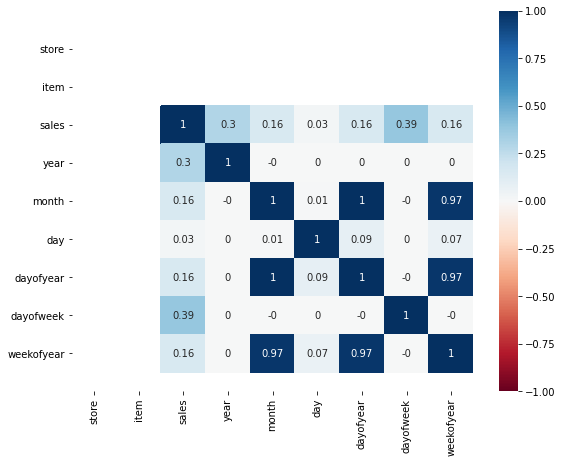

In [51]:
# Como as variáveis numéricas estão correlacionas?
plt.figure(figsize=(9,7))       # tamanho da figura
ax = sns.heatmap(round(df.corr(),2),cmap = "RdBu", vmin= -1, annot = True)
bottom, top = ax.get_ylim()
plt.yticks(rotation=0)
ax.set_ylim(bottom + 0.5, top - 0.5)

Podemos notar que algumas variáveis são altamente correlacionadas. Dessa forma, podemos selecionar uma delas para nosso modelo:

- month e dayofyear
- month e weekofyear

Vamos remover então dayofyear e weekofyear que não está agregando informação.

Além disso, como estamos analisando somente o item 1 store 1, não há variância nesta variável, de forma que não precisamos no nosso modelo. 

In [52]:
# variáveis que serão removidas
var_remover = ['dayofyear','weekofyear','store','item']

In [53]:
# Removendo variáveis
df_train.drop(labels = var_remover,axis = 1, inplace = True)
df_val.drop(labels = var_remover,axis = 1, inplace = True)
df_test.drop(labels = var_remover,axis = 1, inplace = True)

In [54]:
df_train.head()

,date,sales,year,month,day,dayofweek
0,2013-01-01,13,2013,1,1,1
1,2013-01-02,11,2013,1,2,2
2,2013-01-03,14,2013,1,3,3
3,2013-01-04,13,2013,1,4,4
4,2013-01-05,10,2013,1,5,5


Precisamos transformar a variável dayofweek em variáveis dummy.

Por que?

- Quando consideramos a variável inteira, estamos falando que o dia da semana 6 > 5 > 4 > 3 > 2 > 1. E na real, todos os dias da semana devem ter mesmo peso.

Então, como fazemos isso?

In [55]:
days_week = {0:'seg',1: 'ter', 2:'quar',3:'quint',4:'sex',5:'sab',6:'dom'}
days_week.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [56]:
def binary_columns(df,column_reference = 'dayofweek',days_week = {0:'seg',1: 'ter', 2:'quar',3:'quint',4:'sex',5:'sab',6:'dom'}):
  for day in days_week.keys():
    df['day_'+days_week[day]] = df[column_reference].apply(lambda i: 1 if i == day else 0)
  return(df)

binary_columns(df=df_train,column_reference = 'dayofweek',days_week = {0:'seg',1: 'ter', 2:'quar',3:'quint',4:'sex',5:'sab',6:'dom'})
binary_columns(df=df_val,column_reference = 'dayofweek',days_week = {0:'seg',1: 'ter', 2:'quar',3:'quint',4:'sex',5:'sab',6:'dom'})
binary_columns(df=df_test,column_reference = 'dayofweek',days_week = {0:'seg',1: 'ter', 2:'quar',3:'quint',4:'sex',5:'sab',6:'dom'})
df_test.head(3)

,date,sales,year,month,day,dayofweek,day_seg,day_ter,day_quar,day_quint,day_sex,day_sab,day_dom
1734,2017-10-01,21,2017,10,1,6,0,0,0,0,0,0,1
1735,2017-10-02,12,2017,10,2,0,1,0,0,0,0,0,0
1736,2017-10-03,18,2017,10,3,1,0,1,0,0,0,0,0


### 2 - Criando as variáveis X e y

In [57]:
# Separar valores de X e y
names_x = ['year', 'month', 'day', 'day_seg', 'day_ter', 'day_quar',
       'day_quint', 'day_sex', 'day_sab', 'day_dom']
names_y = ['sales']

# Separando grupos:

## treino
X_train = df_train[names_x]
y_train = df_train[names_y]

## validação
X_val = df_val[names_x]
y_val = df_val[names_y]

## teste
X_test = df_test[names_x]
y_test = df_test[names_y]

### 3 - Normalização dos Dados

In [ ]:
from sklearn.preprocessing import StandardScaler

# Passo 1 - Normalização dos dados

# transformar os dados com normalização StandardScaler (normaliza os dados para ter média 0)
sc_x = StandardScaler()                          # chamando a função de normalização
X_train_scale = sc_x.fit_transform(X_train)      # Normaliza X_train
X_val_scale = sc_x.transform(X_val)              # Transforma os dados X_val

# chamando a função de normalização para normalizar y
sc_y = StandardScaler()                    
y_train_scale = sc_y.fit_transform(y_train)


print(X_train_scale)
print('  ')
print(pd.DataFrame(X_train_scale))

In [60]:
print(X_train_scale.shape,y_train_scale.shape)

(1642, 10) (1642, 1)


### 4 - Aplicando o modelo de ML

Regressão linear múltipla

In [61]:
 #regressão linear múltipla
from sklearn.linear_model import LinearRegression

# chamando o módulo da regressão
reg = LinearRegression()

# ajustando os dados na série de treino
reg.fit(X_train_scale,y_train_scale)     

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 5 - Prevendo na série de validação

In [62]:
# prevendo na série de validação
y_pred =  sc_y.inverse_transform(reg.predict(X_val_scale))   

In [ ]:
y_pred

Como podemos ver o resultado?

In [64]:
from plotly.subplots import make_subplots

graf0 = make_subplots(rows=1, cols=1)

graf0.add_trace(go.Scatter(x = df_train['date'],y = df_train['sales'].values,
mode = 'lines',line = dict(width=2),name = 'treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_val['date'],y = df_val['sales'].values,
mode = 'lines',line = dict(width=2),name = 'validaçãoo'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    


# ajuste do treino
graf0.add_trace(go.Scatter(x = df_train['date'],y = sc_y.inverse_transform(reg.predict(X_train_scale)).reshape(-1),
mode = 'lines',line = dict(color = 'black', width=1),name = 'ajuste treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  

# ajuste da validação
graf0.add_trace(go.Scatter(x = df_val['date'],y = y_pred.reshape(-1),
mode = 'lines',line = dict(color = 'black', width=1),name = 'ajuste validação'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  


graf0.update_layout(height=400, width=1100,title={'text': 'Modelo de Regressão Linear Múltipla'},
        plot_bgcolor = 'white',
        font = {'family': 'Arial','size': 16,'color': '#929497'})  # fonte dos textos: família, o tamanho, a cor

graf0.update_xaxes( showgrid = False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497'
)

graf0.update_yaxes(showgrid=False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497')

Como podemos saber se nosso modelo está bom?

### 6 - Avaliando a métrica de avaliação

#### 6.1 - RMSE

In [65]:
# Avaliar nossas métricas obtidas no modelo
import sklearn.metrics
rmse_modelo = sklearn.metrics.mean_squared_error(y_true = y_val.values, y_pred = y_pred, sample_weight=None, multioutput='uniform_average', squared=False)
rmse_modelo

5.562001316544099

#### 6.2 - MAPE

In [67]:
y_true = y_val.values
y_pred = y_pred
MAPE_MODELO = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE_MODELO

16.58584434825076

E agora? Podemos testar outros modelos e outras formas de transformações para conseguirmos melhorar nossa métrica de avaliação e adquirir boas previsões


### 7 - Repetindo o processo com o método SVR

In [69]:
from sklearn.svm import SVR   # os parâmetros padrões do SVR são C:1,epsilon:0.1 e g = auto
import sklearn.metrics

# chamando o módulo da regressão
reg = SVR(kernel = 'rbf',C=1.0, epsilon=0.1)

# ajustando os dados na série de treino
reg.fit(X_train_scale,y_train_scale)     

# prevendo na série de validação
y_pred =  sc_y.inverse_transform(reg.predict(X_val_scale))   

# Avaliar nossas métricas obtidas no modelo

## RMSE
rmse_modelo = sklearn.metrics.mean_squared_error(y_true = y_val.values, y_pred = y_pred, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'RMSE: {rmse_modelo}')

# MAPE
y_true = y_val.values
y_pred = y_pred
MAPE_MODELO = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE_MODELO}')

RMSE: 5.072770487460035
MAPE: 22.48156274145279


In [89]:
from plotly.subplots import make_subplots

graf0 = make_subplots(rows=1, cols=1)

graf0.add_trace(go.Scatter(x = df_train['date'],y = df_train['sales'].values,
mode = 'lines',line = dict(width=2),name = 'treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    

graf0.add_trace(go.Scatter(x = df_val['date'],y = df_val['sales'].values,
mode = 'lines',line = dict(width=2),name = 'validaçãoo'), row=1,col=1)  # grÃ¡fico da variÃ¡vel    


# ajuste do treino
graf0.add_trace(go.Scatter(x = df_train['date'],y = sc_y.inverse_transform(reg.predict(X_train_scale)).reshape(-1),
mode = 'lines',line = dict(color = 'black', width=1),name = 'ajuste treino'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  

# ajuste da validação
graf0.add_trace(go.Scatter(x = df_val['date'],y = y_pred.reshape(-1),
mode = 'lines',line = dict(color = 'black', width=1),name = 'ajuste validação'), row=1,col=1)  # grÃ¡fico da variÃ¡vel  


graf0.update_layout(height=400, width=1100,title={'text': 'Modelo SVR'},
        plot_bgcolor = 'white',
        font = {'family': 'Arial','size': 16,'color': '#929497'})  # fonte dos textos: família, o tamanho, a cor

graf0.update_xaxes( showgrid = False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497'
)

graf0.update_yaxes(showgrid=False, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='#929497')

### 8 - Criando uma rotina mais automática

Agora é com você.
Como fazer um processo mais automático, para testar diferentes métodos e fornecer melhor resultado?

Referências:

- https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

- https://github.com/SouzaCadu/Time-Series/blob/master/Time_series_ML.ipynb

- https://medium.com/data-hackers/s%C3%A9ries-temporais-com-machine-learning-parte-4-6beb3efb2e99
